In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import models
from torch import Tensor
from PIL import Image, ImageOps, ImageDraw, ImageFont
from tqdm.notebook import tqdm
from scipy.optimize import linear_sum_assignment

import itertools
import os
import sys
import json

import cv2
import numpy as np
import random
from typing import Optional, List, Tuple, Dict, Any
from collections import Counter, defaultdict, deque

import matplotlib.pyplot as plt
import matplotlib.patches as patches

NUM_CLASSES = 3

TARGET_SIZE   = (224, 224)
INPUT_SIZE = (224, 224)
IOU_THRESHOLD = 0.04
BBox = Tuple[float, float, float, float]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Check correctness of the dataset (has all files and no black image)

In [ ]:
import os
from collections import Counter
from tqdm import tqdm
import shutil
from PIL import Image
import numpy as np

def check_folder_file_completeness(dataset_dir, save_problematic=True, max_scene_id=2500):
    required_files = {
        'initial_image.png',
        'initial_labels.json',
        'meta.json',
        'target_image.png',
        'target_labels.json'
    }

    # Get all existing rearrangement directories
    existing_dirs = [d for d in os.listdir(dataset_dir)
                    if d.startswith('rearrangement_') and os.path.isdir(os.path.join(dataset_dir, d))]

    # Extract existing scene IDs
    existing_scene_ids = set()
    for dir_name in existing_dirs:
        scene_id = int(dir_name.replace('rearrangement_', ''))
        existing_scene_ids.add(scene_id)

    # Find missing scene IDs
    all_expected_ids = set(range(1, max_scene_id + 1))
    missing_scene_ids = all_expected_ids - existing_scene_ids

    complete_folders = []
    incomplete_folders = []
    folder_issues = {}

    print(f"Checking scene IDs 1 to {max_scene_id}...")
    print(f"Found {len(existing_dirs)} existing folders")
    print(f"Missing {len(missing_scene_ids)} folders")

    # Add missing folders to problematic list
    for scene_id in missing_scene_ids:
        folder_issues[str(scene_id)] = "Missing folder"
        incomplete_folders.append(str(scene_id))

    # Check existing folders for file completeness
    for scene_dir in tqdm(existing_dirs, desc="Checking folder contents"):
        scene_path = os.path.join(dataset_dir, scene_dir)
        scene_id = str(int(scene_dir.replace('rearrangement_', '')))

        try:
            files_in_folder = set(os.listdir(scene_path))
        except Exception as e:
            folder_issues[scene_id] = f"Error reading folder: {e}"
            incomplete_folders.append(scene_id)
            continue

        missing_files = required_files - files_in_folder
        extra_files = files_in_folder - required_files

        # A folder is problematic if it has missing files OR extra files
        if missing_files or extra_files:
            issues = []
            if missing_files:
                issues.append(f"Missing: {sorted(missing_files)}")
            if extra_files:
                issues.append(f"Extra: {sorted(extra_files)}")

            incomplete_folders.append(scene_id)
            folder_issues[scene_id] = "; ".join(issues)
        else:
            complete_folders.append(scene_id)

    if save_problematic and incomplete_folders:
        with open('problematic_scene_ids.txt', 'w') as f:
            f.write(f"# Problematic Scene IDs (1-{max_scene_id})\n")
            f.write(f"# Total problematic: {len(incomplete_folders)}\n")
            f.write(f"# Missing folders: {len(missing_scene_ids)}\n")
            f.write(f"# Incomplete folders: {len(incomplete_folders) - len(missing_scene_ids)}\n")
            f.write("#" + "="*50 + "\n")

            for scene_id in sorted(incomplete_folders, key=int):
                issue = folder_issues.get(scene_id, "Unknown issue")
                f.write(f"{scene_id}  # {issue}\n")
        print(f"Saved {len(incomplete_folders)} problematic scene IDs to 'problematic_scene_ids.txt'")

    print(f"\n=== FOLDER COMPLETENESS SUMMARY ===")
    print(f"Expected scenes: {max_scene_id}")
    print(f"Existing folders: {len(existing_dirs)}")
    print(f"Complete folders: {len(complete_folders)}")
    print(f"Missing folders: {len(missing_scene_ids)}")
    print(f"Incomplete folders: {len(incomplete_folders) - len(missing_scene_ids)}")
    print(f"Total problematic: {len(incomplete_folders)}")
    print(f"Completion rate: {len(complete_folders)/max_scene_id*100:.2f}%")

    if folder_issues:
        print(f"\n=== SAMPLE FOLDER ISSUES ===")
        sample_issues = list(folder_issues.items())[:10]
        for scene_id, issue in sample_issues:
            print(f"Scene {scene_id}: {issue}")
        if len(folder_issues) > 10:
            print(f"... and {len(folder_issues) - 10} more folders with issues")

    return {
        'complete_scene_ids': sorted([int(x) for x in complete_folders]),
        'incomplete_scene_ids': sorted([int(x) for x in incomplete_folders]),
        'missing_scene_ids': sorted(list(missing_scene_ids)),
        'folder_issues': folder_issues
    }

def load_problematic_scene_ids(txt_file):
    scene_ids = []

    if not os.path.exists(txt_file):
        print(f"File {txt_file} not found!")
        return scene_ids

    with open(txt_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('#') or not line:
                continue
            scene_id = line.split('#')[0].strip()
            if scene_id.isdigit():
                scene_ids.append(scene_id)

    return scene_ids

def remove_scenes_from_file(dataset_dir, txt_file, dry_run: bool = True):
    problematic_scene_ids = load_problematic_scene_ids(txt_file)

    if not problematic_scene_ids:
        print("No problematic scene IDs found in the file.")
        return

    print(f"Loaded {len(problematic_scene_ids)} scene IDs from {txt_file}")

    removed_count = 0
    not_found_count = 0

    for scene_id in tqdm(problematic_scene_ids, desc="Processing scenes"):
        folder_name = f"rearrangement_{scene_id.zfill(5)}"
        folder_path = os.path.join(dataset_dir, folder_name)

        if os.path.exists(folder_path):
            if dry_run:
                print(f"Would remove: {folder_path}")
            else:
                try:
                    shutil.rmtree(folder_path)
                    print(f"Removed: {folder_path}")
                    removed_count += 1
                except Exception as e:
                    print(f"Error removing {folder_path}: {e}")
        else:
            not_found_count += 1

    print(f"\n=== REMOVAL SUMMARY ===")
    if dry_run:
        print(f"DRY RUN: Found {len(problematic_scene_ids)} scenes to process")
        print(f"Folders that would be removed: {len(problematic_scene_ids) - not_found_count}")
        print(f"Missing folders (already absent): {not_found_count}")
        print("Set dry_run=False to actually delete the folders.")
    else:
        print(f"Successfully removed: {removed_count} folders")
        print(f"Missing folders (already absent): {not_found_count}")
        print(f"Total processed: {len(problematic_scene_ids)}")

def is_image_black(image_path, threshold: float = 0.01) -> bool:
    """Check if an image is completely black."""
    try:
        image = Image.open(image_path)
        img_array = np.array(image) / 255.0
        return np.mean(img_array) < threshold
    except Exception as e:
        print(f"Error checking image {image_path}: {e}")
        return False

def find_black_image_scenes(dataset_dir):
    rearrangement_dirs = [d for d in os.listdir(dataset_dir)
                         if d.startswith('rearrangement_') and os.path.isdir(os.path.join(dataset_dir, d))]

    problematic_scenes = []

    for scene_dir in tqdm(rearrangement_dirs, desc="Checking for black images"):
        scene_path = os.path.join(dataset_dir, scene_dir)
        scene_id = str(int(scene_dir.replace('rearrangement_', '')))

        initial_img = os.path.join(scene_path, 'initial_image.png')
        target_img = os.path.join(scene_path, 'target_image.png')

        initial_black = os.path.exists(initial_img) and is_image_black(initial_img)
        target_black = os.path.exists(target_img) and is_image_black(target_img)

        if initial_black or target_black:
            problematic_scenes.append(scene_id)

    return problematic_scenes

def create_combined_report(dataset_dir, report_file, check_black_images: bool = True, max_scene_id: int = 2500):
    # Get file completeness issues
    file_completeness_result = check_folder_file_completeness(dataset_dir, save_problematic=False, max_scene_id=max_scene_id)

    # Get black image issues if enabled
    black_image_scenes = []
    if check_black_images:
        black_image_scenes = find_black_image_scenes(dataset_dir)

    # Combine problematic scene IDs
    all_problematic = set(map(str, file_completeness_result['incomplete_scene_ids'])) | set(black_image_scenes)
    folder_issues = file_completeness_result['folder_issues'].copy()

    # Add black image issues
    for scene_id in black_image_scenes:
        if scene_id not in folder_issues:
            folder_issues[scene_id] = "Black images"
        else:
            folder_issues[scene_id] += "; Black images"

    # Save combined report
    if all_problematic:
        with open(report_file, 'w') as f:
            f.write(f"# Problematic Scene IDs (File Issues{' + Black Images' if check_black_images else ''})\n")
            f.write(f"# Total problematic: {len(all_problematic)}\n")
            f.write(f"# File issues: {len(file_completeness_result['incomplete_scene_ids'])}\n")
            if check_black_images:
                f.write(f"# Black images: {len(black_image_scenes)}\n")
            f.write("#" + "="*50 + "\n")

            for scene_id in sorted(all_problematic, key=int):
                issue = folder_issues.get(scene_id, "Unknown issue")
                f.write(f"{scene_id}  # {issue}\n")
        print(f"Saved {len(all_problematic)} problematic scene IDs to '{report_file}'")

    print(f"\n=== COMBINED SUMMARY ===")
    print(f"File completeness issues: {len(file_completeness_result['incomplete_scene_ids'])}")
    if check_black_images:
        print(f"Black image issues: {len(black_image_scenes)}")
    print(f"Total unique problematic scenes: {len(all_problematic)}")

    return all_problematic

def copy_problematic_scenes_to_folder(dataset_dir, output_dir, txt_file):
    problematic_scene_ids = load_problematic_scene_ids(txt_file)

    if not problematic_scene_ids:
        print("No problematic scene IDs found in the file.")
        return

    os.makedirs(output_dir, exist_ok=True)
    print(f"Created output directory: {output_dir}")

    copied_count = 0
    not_found_count = 0

    for scene_id in tqdm(problematic_scene_ids, desc="Copying scenes"):
        folder_name = f"rearrangement_{scene_id.zfill(5)}"
        source_path = os.path.join(dataset_dir, folder_name)
        dest_path = os.path.join(output_dir, folder_name)

        if os.path.exists(source_path):
            try:
                shutil.copytree(source_path, dest_path)
                copied_count += 1
            except Exception as e:
                print(f"Error copying {source_path}: {e}")
        else:
            not_found_count += 1

    print(f"\n=== COPY SUMMARY ===")
    print(f"Successfully copied: {copied_count} folders")
    print(f"Missing folders (not found): {not_found_count}")
    print(f"Total processed: {len(problematic_scene_ids)}")


In [ ]:
dataset_dir = "/content/drive/MyDrive/DBRP/dataset-sim"
report_file = "/content/problematic_scene_ids.txt"

# Remove the report file if it exists
if os.path.exists(report_file):
    os.remove(report_file)
    print(f"Removed existing {report_file}")

# Create combined report with black image checking enabled
all_problematic = create_combined_report(dataset_dir, report_file, check_black_images=False)

In [ ]:
# First do a dry run to see what would be deleted (run in problematic version)
print("=== DRY RUN ===")
remove_scenes_from_file(dataset_dir, report_file, dry_run=True)

# Apply CNN on the dataset-sim

In [2]:
import pathlib
pathlib.PosixPath = pathlib.WindowsPath
sys.path.append("./core/perception/yolov5")
from utils.augmentations import letterbox
from utils.general import non_max_suppression, scale_boxes
%matplotlib inline

# ===============================YOLO===============================

def load_yolo(weights_path: str, device: Optional[str] = None):
	if device is None:
		device = "cuda" if torch.cuda.is_available() else "cpu"

	yolo = torch.hub.load(
		"ultralytics/yolov5",
		"custom",
		path=weights_path,
		autoshape=False,
		force_reload=True, 
		device='cpu'
	).eval()

	return yolo

@torch.inference_mode()
def detect_objects(
		model,
		pil_image,
		device="cuda" if torch.cuda.is_available() else "cpu",
		imgsz=640,
		conf_thres=0.35,
		iou_thres=0.45,
):
	model.to(device).eval()

	img0 = np.array(pil_image)[:, :, ::-1]

	stride = model.stride
	if not isinstance(stride, (int, float)):
		stride = max(stride)
	stride = int(stride)

	img = letterbox(img0, imgsz, stride=stride, auto=True)[0]

	img = img[:, :, ::-1].transpose(2, 0, 1)
	img = np.ascontiguousarray(img)
	img = torch.from_numpy(img).to(device).float() / 255.0
	img = img.unsqueeze(0)

	pred = model(img)[0]

	det = non_max_suppression(pred, conf_thres, iou_thres, max_det=300)[0]

	if det is None or not len(det):
		return []

	det[:, :4] = scale_boxes(img.shape[2:], det[:, :4], img0.shape).round()

	results = [
		{
			"bbox":   [int(x1), int(y1), int(x2), int(y2)],
			"confidence": float(conf),
			"class":     int(cls),
		}
		for (x1, y1, x2, y2, conf, cls) in det.cpu().numpy()
	]
	return results

yolo_path = "./core/models/yolov5_sim.pt"
yolo = load_yolo(yolo_path)
class_map = {k: ('pot' if v == 'pan' else v) for k, v in yolo.names.items()}

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\arman/.cache\torch\hub\master.zip
YOLOv5  2025-8-26 Python-3.8.10 torch-2.4.1+cpu CPU



In [ ]:
def cal_iou(box1: BBox, box2: BBox) -> float:
	"""Calculates IoU for boxes in [xmin, ymin, xmax, ymax] format."""
	# Determine the coordinates of the intersection rectangle
	inter_x1 = max(box1[0], box2[0])
	inter_y1 = max(box1[1], box2[1])
	inter_x2 = min(box1[2], box2[2])
	inter_y2 = min(box1[3], box2[3])

	# Compute the area of intersection
	inter_w = max(0, inter_x2 - inter_x1)
	inter_h = max(0, inter_y2 - inter_y1)
	inter_area = inter_w * inter_h

	# Compute the area of both bounding boxes
	area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
	area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

	# Compute the area of union
	union_area = area1 + area2 - inter_area
	return inter_area / union_area if union_area > 0 else 0.0

def plot_detections(image, detections, class_map=None, ax=None, title=None):
	"""
	Plots an image and overlays bounding boxes from detections on a given ax.
	"""
	if isinstance(image, str):
		try:
			image = Image.open(image)
		except FileNotFoundError:
			print(f"Error: Image file not found at {image}")
			return

	# If no axes is provided, create a new figure and axes
	show_plot = False
	if ax is None:
		fig, ax = plt.subplots(1, figsize=(10, 6))
		show_plot = True

	ax.imshow(image)

	for i, det in enumerate(detections):
		bbox = det['bbox']
		xmin, ymin, xmax, ymax = bbox
		width = xmax - xmin
		height = ymax - ymin

		# Create a Rectangle patch
		rect = patches.Rectangle(
			(xmin, ymin), width, height,
			linewidth=2, edgecolor='lime', facecolor='none'
		)
		ax.add_patch(rect)

		# Add a label
		label_parts = []
		if class_map:
			label_parts.append(f"({i})")
			label_parts.append(class_map.get(det['class'], f"ID {det['class']}"))
		if 'confidence' in det:
			label_parts.append(f"{det['confidence']:.2f}")

		if label_parts:
			ax.text(
				xmin, ymin - 5, " ".join(label_parts),
				color='black', fontsize=8,
				bbox=dict(facecolor='lime', alpha=0.7, pad=1, edgecolor='none')
			)

	ax.axis('off')
	if title:
		ax.set_title(title)

	# Only call plt.show() if we created the figure inside this function
	if show_plot:
		plt.tight_layout()
		plt.show()

def filter_duplicate_detections(
	detections,
	same_class_iou_thres=0.65,
	cross_class_iou_thres=0.90
):
	"""
	Filters out duplicate detections using Non-Maximum Suppression (NMS).

	This function handles both same-class and cross-class duplicates. It keeps
	the detection with the highest confidence and removes others that have a
	high overlap (IoU).

	Args:
		detections (list): A list of detected objects from YOLO.
						Each detection is a dict with 'bbox', 'confidence', and 'class'.
		same_class_iou_thres (float): The IoU threshold for detections of the same class.
		cross_class_iou_thres (float): The IoU threshold for detections of different classes.
									This should be high to only remove clear duplicates.

	Returns:
		list: A new list of filtered detections.
	"""
	# Sort detections by confidence in descending order
	dets = sorted(detections, key=lambda d: d["confidence"], reverse=True)

	kept_detections = []
	while dets:
		# Keep the detection with the highest confidence
		best_det = dets.pop(0)
		kept_detections.append(best_det)

		# Remove other detections that have a high IoU
		remaining_dets = []
		for d in dets:
			iou = cal_iou(best_det['bbox'], d['bbox'])

			# Check for same-class duplicates
			if d['class'] == best_det['class']:
				if iou <= same_class_iou_thres:
					remaining_dets.append(d)
			# Check for cross-class duplicates (high overlap but different class)
			else:
				if iou <= cross_class_iou_thres:
					remaining_dets.append(d)
		dets = remaining_dets

	return kept_detections

def sort_and_validate_detections(label_file_path, det, class_map):
    """
    Sorts and validates detected objects against a ground-truth label file using the
    Hungarian algorithm for optimal assignment.
    """
    with open(label_file_path, 'r') as f:
        labels = json.load(f)

    gt_objects = sorted(labels['objects'], key=lambda x: x['obj_id'])

    if len(det) != len(gt_objects):
        raise ValueError(f"Mismatch in object count. Expected {len(gt_objects)}, but detected {len(det)}.")

    id_to_name = {v: k for k, v in class_map.items()}

    # Group ground-truth and detected objects by class
    gt_by_class = defaultdict(list)
    for gt_obj in gt_objects:
        gt_class_id = id_to_name.get(gt_obj['model_name'])
        if gt_class_id is None:
            raise ValueError(f"Model name '{gt_obj['model_name']}' not in class_map.")
        gt_by_class[gt_class_id].append(gt_obj)

    det_by_class = defaultdict(list)
    for d in det:
        det_by_class[d['class']].append(d)

    # Check if class counts match
    if Counter(k for k in gt_by_class) != Counter(k for k in det_by_class):
        raise ValueError(f"Class mismatch. GT: {Counter(k for k in gt_by_class)}, Det: {Counter(k for k in det_by_class)}")

    sorted_det = [None] * len(gt_objects)

    # For each class, find the optimal assignment
    for class_id, gts in gt_by_class.items():
        dets = det_by_class[class_id]
        if len(gts) != len(dets):
            raise ValueError(f"Mismatch in object count for class {class_id}. Expected {len(gts)}, detected {len(dets)}.")

        # Create a cost matrix (1 - IoU)
        cost_matrix = np.zeros((len(gts), len(dets)))
        for i, gt_obj in enumerate(gts):
            for j, detected_obj in enumerate(dets):
                iou = cal_iou(gt_obj['bbox'], detected_obj['bbox'])
                cost_matrix[i, j] = 1 - iou

        # Use the Hungarian algorithm to find the minimum cost assignment
        gt_indices, det_indices = linear_sum_assignment(cost_matrix)

        # Assign the matched detections
        for gt_idx, det_idx in zip(gt_indices, det_indices):
            gt_obj_id = gts[gt_idx]['obj_id']
            sorted_det[gt_obj_id] = dets[det_idx]

    # Final check to ensure all objects were assigned
    if any(d is None for d in sorted_det):
        unassigned_ids = [i for i, d in enumerate(sorted_det) if d is None]
        raise RuntimeError(f"Failed to assign all objects. Unassigned GT IDs: {unassigned_ids}")

    return sorted_det

def match_target_detections_by_distance(initial_sorted_dets, target_dets):
	"""
	Matches target detections to initial detections by minimizing bbox center distance.

	For classes with a single instance, it performs a direct match. For classes
	with multiple instances, it uses the Hungarian algorithm to find the optimal
	assignment that minimizes the sum of Euclidean distances between the centers
	of the bounding boxes.

	Args:
		initial_sorted_dets (list): A list of sorted detections from the initial scene.
		target_dets (list): A list of filtered detections from the target scene.

	Returns:
		list: A new list of target detections sorted to match the initial detections.

	Raises:
		ValueError: If the object classes in the target scene do not match the initial scene.
	"""
	# --- Validation ---
	initial_classes = Counter(d['class'] for d in initial_sorted_dets)
	target_classes = Counter(d['class'] for d in target_dets)
	if initial_classes != target_classes:
		raise ValueError(f"Object mismatch. Initial: {initial_classes}, Target: {target_classes}")

	# --- Helper Functions ---
	def get_bbox_center(det):
		box = det['bbox']
		return np.array([(box[0] + box[2]) / 2, (box[1] + box[3]) / 2])

	# --- Setup ---
	sorted_target_list = [None] * len(initial_sorted_dets)

	# Group initial and target detections by class
	initial_by_class = defaultdict(list)
	for i, det in enumerate(initial_sorted_dets):
		initial_by_class[det['class']].append({'idx': i, 'det': det})

	target_by_class = defaultdict(list)
	for det in target_dets:
		target_by_class[det['class']].append(det)

	# --- Match objects ---
	for class_id, initial_dets in initial_by_class.items():
		target_dets_for_class = target_by_class[class_id]

		if len(initial_dets) == 1:
			# Simple case: unique object
			sorted_target_list[initial_dets[0]['idx']] = target_dets_for_class[0]
		else:
			# Complex case: multiple objects of the same class
			# Create a cost matrix of distances
			num_instances = len(initial_dets)
			cost_matrix = np.zeros((num_instances, num_instances))

			for i in range(num_instances):
				for j in range(num_instances):
					center_initial = get_bbox_center(initial_dets[i]['det'])
					center_target = get_bbox_center(target_dets_for_class[j])
					cost_matrix[i, j] = np.linalg.norm(center_initial - center_target)

			# Find the optimal assignment using the Hungarian algorithm
			row_ind, col_ind = linear_sum_assignment(cost_matrix)

			# Assign the matched objects
			for i, j in zip(row_ind, col_ind):
				initial_idx = initial_dets[i]['idx']
				sorted_target_list[initial_idx] = target_dets_for_class[j]

	return sorted_target_list



🔄 Loaded checkpoint ./core/models/SRI.pt


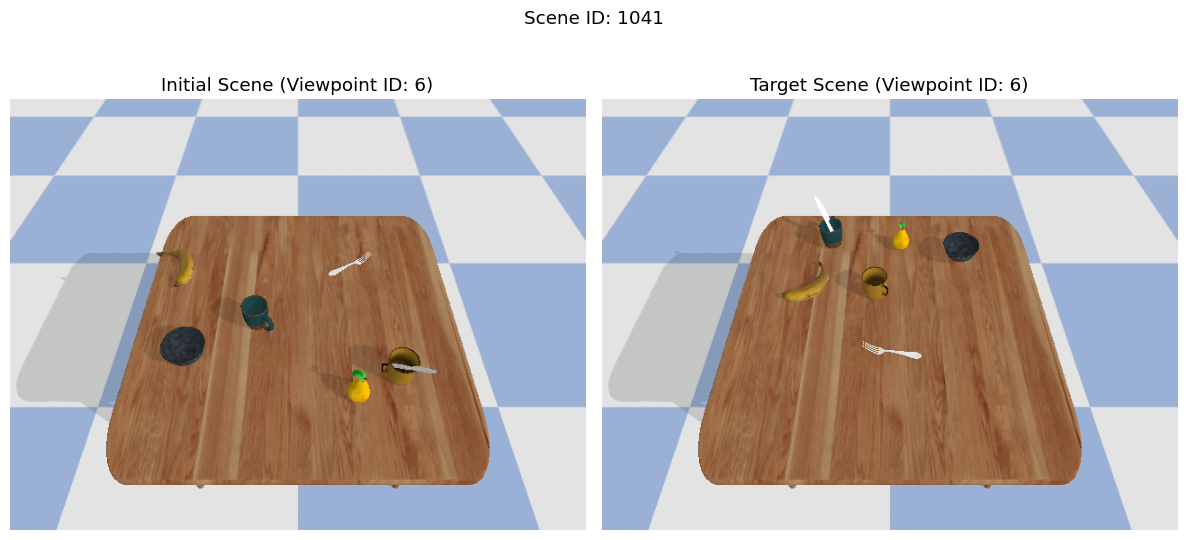

In [38]:
%matplotlib inline
from core.sim.rearrangemet_loader import select_rearrangement_dir, visualize_rearrangement

# ===============================SRD===============================

def load_model(checkpoint_path: str):
	# Model (identical architecture to training) ------------------------------
	# resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
	resnet = models.resnet50(weights=None)

	old_conv = resnet.conv1
	new_conv = nn.Conv2d(
		5,
		old_conv.out_channels,
		kernel_size=old_conv.kernel_size,
		stride=old_conv.stride,
		padding=old_conv.padding,
		bias=False,
	)
	with torch.no_grad():
		new_conv.weight[:, :3] = old_conv.weight          # copy RGB weights
		mean_w = old_conv.weight.mean(dim=1, keepdim=True)
		new_conv.weight[:, 3:5] = mean_w.repeat(1, 2, 1, 1)
	resnet.conv1 = new_conv

	resnet.fc = nn.Linear(resnet.fc.in_features, NUM_CLASSES)
	resnet = resnet.to(DEVICE)

	# Load checkpoint ----------------------------------------------------------
	ckpt = torch.load(checkpoint_path, map_location=DEVICE)
	resnet.load_state_dict(ckpt["model_state_dict"])
	# optimizer.load_state_dict(ckpt["optimizer_state_dict"])
	start_epoch = ckpt["epoch"] + 1
	best_val_acc = ckpt["best_val_acc"]
	global_step = ckpt.get("global_step", {"train": 0, "val": 0})
	print(f"\n🔄 Loaded checkpoint {checkpoint_path}")

	resnet.eval()
	return resnet

def guess_label_path(image_path: str) -> str:
	"""Derive a mask-image path from the RGB image path."""
	candidate = image_path.replace("_image", "_labels")
	candidate = candidate.replace(".png", ".json")
	return candidate

def read_instance_masks(label_path: str) -> Dict[int, np.ndarray]:
	"""Return `{instance_id: binary_mask}` for every non-zero ID in label PNG."""
	lbl = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
	if lbl is None:
		raise FileNotFoundError(f"Mask image not found: {label_path}")
	ids = [int(i) for i in np.unique(lbl) if i != 0]
	masks = {i: (lbl == i).astype(np.uint8) for i in ids}
	return masks

def union_box(box1: BBox, box2: BBox) -> BBox:
	"""Return the bounding rectangle that encloses *both* input boxes."""
	xmin = min(box1[0], box2[0])
	ymin = min(box1[1], box2[1])
	xmax = max(box1[2], box2[2])
	ymax = max(box1[3], box2[3])
	return xmin, ymin, xmax, ymax

def bbox_map(mask: np.ndarray) -> np.ndarray:
	"""Binary image with ones inside the bounding box of *mask*."""
	y, x = np.where(mask > 0)
	if len(x) == 0:
		return np.zeros_like(mask, dtype=np.uint8)
	x1, x2 = x.min(), x.max()
	y1, y2 = y.min(), y.max()
	out = np.zeros_like(mask, dtype=np.uint8)
	out[y1 : y2 + 1, x1 : x2 + 1] = 1
	return out

def build_five_channel(mask1: np.ndarray, mask2: np.ndarray) -> np.ndarray:
	"""Return 5×H×W float32 tensor for a mask pair."""
	overlap = np.logical_and(mask1, mask2).astype(np.uint8)
	ch = np.stack(
		[
			mask1.astype(np.float32),
			mask2.astype(np.float32),
			bbox_map(mask1).astype(np.float32),
			bbox_map(mask2).astype(np.float32),
			overlap.astype(np.float32),
		],
		axis=0,
	)
	return ch

def resize_tensor(t: np.ndarray, size_xy: Tuple[int, int]) -> np.ndarray:
	"""Nearest-neighbour resize of C×H×W to *size_xy* (wxh)."""
	c, h, w = t.shape
	out = np.empty((c, size_xy[1], size_xy[0]), dtype=np.float32)
	for i in range(c):
		out[i] = cv2.resize(t[i], size_xy, interpolation=cv2.INTER_NEAREST)
	return out

def predict_single(model, backend: str, tensor5: np.ndarray) -> np.ndarray:
	"""Forward pass of a *single* 5-channel sample – returns 3-element numpy."""
	if backend == "torch":
		import torch

		x = torch.from_numpy(tensor5).unsqueeze(0)
		with torch.no_grad():
			y = model(x).squeeze(0).cpu().numpy()
		return y

	x = tensor5.transpose(1, 2, 0)[None, ...]
	y = model.predict(x, verbose=0)[0]
	return y

def classify_pair(vec1: np.ndarray, vec2: np.ndarray) -> str:
	"""Return “mask2_parent”, “mask1_parent” or “none”."""
	v1 = vec1.copy()
	v1[0], v1[1] = v1[1], v1[0]
	combined = v1 + vec2
	onehot = np.zeros_like(combined, dtype=int)
	onehot[np.argmax(combined)] = 1
	if onehot[0] == 1:
		return "mask2_parent"
	if onehot[1] == 1:
		return "mask1_parent"
	return "none"

def bbox_to_slice(bbox):
	x1, y1, x2, y2 = map(int, bbox)
	return slice(y1, y2), slice(x1, x2)

def square_bbox(bbox, img_w, img_h):
	x1, y1, x2, y2 = map(float, bbox)
	w, h = x2 - x1, y2 - y1
	cx, cy = x1 + w / 2, y1 + h / 2
	side = max(w, h)
	half = side / 2
	new_x1, new_y1 = cx - half, cy - half
	new_x2, new_y2 = cx + half, cy + half

	new_x1, new_y1 = max(0, new_x1), max(0, new_y1)
	new_x2, new_y2 = min(img_w, new_x2), min(img_h, new_y2)

	new_w, new_h = new_x2 - new_x1, new_y2 - new_y1
	if new_w != side:
		diff = side - new_w
		if new_x1 - diff >= 0:
			new_x1 -= diff
		else:
			new_x2 += diff
	if new_h != side:
		diff = side - new_h
		if new_y1 - diff >= 0:
			new_y1 -= diff
		else:
			new_y2 += diff
	return [int(round(v)) for v in (new_x1, new_y1, new_x2, new_y2)]

def _filter_transitive_pairs(edges: List[Tuple[int, int]]) -> List[Tuple[int, int]]:
	adj: dict[int, set[int]] = defaultdict(set)
	for p, c in edges:
		adj[p].add(c)

	keep = []
	for parent, child in edges:
		queue = deque(adj[parent] - {child})
		visited = set(queue)
		redundant = False
		while queue and not redundant:
			node = queue.popleft()
			if node == child:
				redundant = True
				break
			queue.extend(n for n in adj[node] if n not in visited)
			visited.update(adj[node])
		if not redundant:
			keep.append((parent, child))
	return keep

def compute_scene_relation_graph(
    image_path: str,
    bboxes: list,
    model,
    iou_threshold: float = IOU_THRESHOLD,
    device: str = DEVICE,
    target_size: tuple = TARGET_SIZE,
) -> list:
    """
    Computes parent-child relations for a scene given an image and a list of bounding boxes.

    Args:
        image_path (str): Path to the scene image.
        bboxes (list): List of bounding boxes (each as [xmin, ymin, xmax, ymax]).
        model: The SRI model.
        iou_threshold (float): IoU threshold for considering pairs.
        device (str): Device for model inference.
        target_size (tuple): Size to which crops are resized.

    Returns:
        List[Tuple[int, int]]: List of (parent_idx, child_idx) pairs.
    """
    img = Image.open(image_path).convert("RGB")
    img_w, img_h = img.size
    img_arr = np.asarray(img, dtype=np.float32) / 255.0

    ids = list(range(len(bboxes)))
    parent_pairs = []

    for id1, id2 in itertools.combinations(ids, 2):
        b1 = tuple(map(float, bboxes[id1]))
        b2 = tuple(map(float, bboxes[id2]))
        un_mask = union_box(b1, b2)

        if cal_iou(b1, b2) <= iou_threshold:
            continue

        mask1 = np.zeros((img_h, img_w), dtype=np.float32)
        mask2 = np.zeros((img_h, img_w), dtype=np.float32)
        mask1[bbox_to_slice(b1)] = 1.0
        mask2[bbox_to_slice(b2)] = 1.0

        sq_bbox = square_bbox(un_mask, img_w, img_h)
        s = bbox_to_slice(sq_bbox)
        rgb_crop = img_arr[s]
        m1_crop = mask1[s][..., None]
        m2_crop = mask2[s][..., None]

        rgb_resized = cv2.resize(rgb_crop, target_size, interpolation=cv2.INTER_LINEAR)
        m1_resized = cv2.resize(m1_crop, target_size, interpolation=cv2.INTER_NEAREST)
        m2_resized = cv2.resize(m2_crop, target_size, interpolation=cv2.INTER_NEAREST)

        stacked12 = np.concatenate([rgb_resized, m1_resized[..., None], m2_resized[..., None]], axis=-1)
        stacked21 = np.concatenate([rgb_resized, m2_resized[..., None], m1_resized[..., None]], axis=-1)

        tensor12 = torch.from_numpy(stacked12).permute(2, 0, 1).unsqueeze(0).to(device)
        tensor21 = torch.from_numpy(stacked21).permute(2, 0, 1).unsqueeze(0).to(device)

        v12 = model(tensor12).squeeze(0).cpu().detach().numpy()
        v21 = model(tensor21).squeeze(0).cpu().detach().numpy()
        relation = classify_pair(v12, v21)

        if relation == "mask2_parent":
            parent_pairs.append((id2, id1))
        elif relation == "mask1_parent":
            parent_pairs.append((id1, id2))

    parent_pairs = _filter_transitive_pairs(parent_pairs)
    return parent_pairs

def print_rearrangement_scene_graphs(
	dataset_dir: str, scene_id: Optional[int], model
):
	"""
	Visualizes the initial and target scene relation graphs of a rearrangement.
	"""
	try:
		selected_dir_path, scene_id_val = select_rearrangement_dir(
			dataset_dir, scene_id
		)
	except FileNotFoundError as e:
		print(e)
		return

	print(f"\nAnalyzing Scene ID: {scene_id_val}")
	print("-" * 30)

	for scene_type in ["initial", "target"]:
		image_path = os.path.join(selected_dir_path, f"{scene_type}_image.png")
		label_path = os.path.join(selected_dir_path, f"{scene_type}_labels.json")

		if not os.path.exists(image_path) or not os.path.exists(label_path):
			print(f"Files for {scene_type} scene not found, skipping.")
			continue

		with open(label_path, "r") as f:
			objs = json.load(f)

		if not isinstance(objs, list):
			objs = objs['objects']

		name_of = {
			o["obj_id"]: o.get("model_id", f"id_{o['obj_id']}") for o in objs
		}

		gt_bboxes = [o["bbox"] for o in objs]
		parent_pairs = compute_scene_relation_graph(image_path, gt_bboxes, model)

		print(f"Detected parent-child relations in '{scene_type}_image.png':")
		if not parent_pairs:
			print("  No relations found.")
		else:
			for p_id, c_id in parent_pairs:
				p_name = name_of.get(p_id, f"id_{p_id}")
				c_name = name_of.get(c_id, f"id_{c_id}")
				print(f"  {p_name} ({p_id})  ⟶  {c_name} ({c_id})")
		print("-" * 30)

dataset_dir = "./dataset-sim"
model = load_model("./core/models/SRI.pt")
model = model.to(DEVICE)

folder_path, scene_id = select_rearrangement_dir(dataset_dir, scene_id=None, viewpoint_id=None)
visualize_rearrangement(dataset_dir, scene_id=scene_id)

In [24]:
import numpy as np
from collections import defaultdict
from scipy.optimize import linear_sum_assignment
from typing import List, Dict

# A type hint for clarity
Detection = Dict[str, any]

def _apply_nms_to_scene(detections: List[Detection], iou_threshold: float) -> List[Detection]:
    """
    Applies Non-Maximum Suppression to a single list of detections on a per-class basis.
    """
    # Group detections by class to apply NMS independently for each class
    grouped_dets = defaultdict(list)
    for det in detections:
        grouped_dets[det['class']].append(det)

    final_detections = []
    for class_id, dets in grouped_dets.items():
        # Sort detections by confidence in descending order
        dets = sorted(dets, key=lambda d: d['confidence'], reverse=True)
        
        kept_dets = []
        while dets:
            best_det = dets.pop(0)
            kept_dets.append(best_det)
            
            # Keep only the detections that do not have a high IoU with the best one
            remaining_dets = []
            for d in dets:
                if cal_iou(best_det['bbox'], d['bbox']) <= iou_threshold:
                    remaining_dets.append(d)
            dets = remaining_dets
        
        final_detections.extend(kept_dets)
        
    return final_detections

def reciprocal_filter_with_nms(
    detections_A: List[Detection], 
    detections_B: List[Detection], 
    iou_threshold: float = 0.5
) -> (List[Detection], List[Detection]):
    """
    Filters two sets of detections using a two-stage process:
    1. Intra-Scene NMS: Removes spatially overlapping boxes within each scene.
    2. Inter-Scene Mutual Filter: Finds mutually confident matches between the scenes.

    Args:
        detections_A (list): Raw detections from the first scene.
        detections_B (list): Raw detections from the second scene.
        iou_threshold (float): The IoU threshold for the NMS step.

    Returns:
        tuple[list, list]: The final, doubly-filtered detection lists for scene A and B.
    """
    # 1. Apply Non-Maximum Suppression to each scene independently
    print(f"Scene A: Starting with {len(detections_A)} raw detections.")
    nms_filtered_A = _apply_nms_to_scene(detections_A, iou_threshold)
    print(f"Scene A: {len(nms_filtered_A)} detections remaining after NMS.")

    print(f"Scene B: Starting with {len(detections_B)} raw detections.")
    nms_filtered_B = _apply_nms_to_scene(detections_B, iou_threshold)
    print(f"Scene B: {len(nms_filtered_B)} detections remaining after NMS.")

    # 2. Perform the mutual confidence filtering on the cleaned-up lists
    # This logic is identical to your original mutual_filter_by_confidence function
    grouped_A = defaultdict(list)
    for det in nms_filtered_A:
        grouped_A[det['class']].append(det)

    grouped_B = defaultdict(list)
    for det in nms_filtered_B:
        grouped_B[det['class']].append(det)

    final_A = []
    final_B = []

    all_classes = set(grouped_A.keys()) | set(grouped_B.keys())

    for class_id in all_classes:
        dets_A = grouped_A.get(class_id, [])
        dets_B = grouped_B.get(class_id, [])

        if not dets_A or not dets_B:
            continue

        num_A, num_B = len(dets_A), len(dets_B)
        cost_matrix = np.zeros((num_A, num_B))

        for i in range(num_A):
            for j in range(num_B):
                conf_A = dets_A[i]['confidence']
                conf_B = dets_B[j]['confidence']
                cost_matrix[i, j] = 1 - (conf_A * conf_B)

        row_ind, col_ind = linear_sum_assignment(cost_matrix)

        for i, j in zip(row_ind, col_ind):
            final_A.append(dets_A[i])
            final_B.append(dets_B[j])
            
    print(f"Mutual filtering complete. Final count for both scenes: {len(final_A)}.")
    return final_A, final_B

def create_x_from_det(det_init, det_trgt, init_img_path, trgt_img_path, model, viewpoint_id, class_map):
	num_objects = len(det_init)

	sim = PyBulletSim(p.DIRECT)
	grid_size = (100, 100)
	table = load_table_urdf(OBJS_DIR, grid_size)
	z = get_object_extents(table)[2]
	cam = CameraManager()
	cam.set_viewpoint(target_pos=[0, 0, z], viewpoint_id=viewpoint_id)

	x_init = torch.zeros((num_objects, num_objects+5), dtype=torch.long)
	x_trgt = torch.zeros((num_objects, num_objects+5), dtype=torch.long)
	for i in range(len(det_init)):
		model_name = class_map[det_init[i]['class']]
		label = next((k for k, v in OBJECTS.items() if v['name'] == model_name), None)
		size = OBJECTS[label]['size']
		bbox = det_init[i]['bbox']
		u, v = (bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2
		obj_pos = cam.project_pixel_to_world(u, v, n=np.array([0, 0, 1]), p0=np.array([0, 0, z+0.05]))
		grid_pos = world_to_grid_coords(obj_pos, grid_size=grid_size)
		x_init[i, 0] = label
		x_init[i, 1] = size[0]
		x_init[i, 2] = size[1]
		x_init[i, 3] = grid_pos[0]
		x_init[i, 4] = grid_pos[1]

		bbox = det_trgt[i]['bbox']
		u, v = (bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2
		obj_pos = cam.project_pixel_to_world(u, v, n=np.array([0, 0, 1]), p0=np.array([0, 0, z+0.05]))
		grid_pos = world_to_grid_coords(obj_pos, grid_size=grid_size)
		x_trgt[i, 0] = label
		x_trgt[i, 1] = size[0]
		x_trgt[i, 2] = size[1]
		x_trgt[i, 3] = grid_pos[0]
		x_trgt[i, 4] = grid_pos[1]
	
	sim.close()

	init_bboxes = [o["bbox"] for o in det_init]
	init_pairs = compute_scene_relation_graph(init_img_path, init_bboxes, model)
	print("Initial Scene")
	for stacked_id, base_id in init_pairs:
		print(f"  {stacked_id}  ⟶  {base_id}")
		x_init[stacked_id, Indices.RELATION.start + base_id] = 1
		x_init[stacked_id, Indices.COORD] = x_init[base_id, Indices.COORD].clone()

	trgt_bboxes = [o["bbox"] for o in det_trgt]
	trgt_pairs = compute_scene_relation_graph(trgt_img_path, trgt_bboxes, model)
	print("Target Scene")
	for stacked_id, base_id in trgt_pairs:
		print(f"  {stacked_id}  ⟶  {base_id}")
		x_trgt[stacked_id, Indices.RELATION.start + base_id] = 1
		x_trgt[stacked_id, Indices.COORD] = x_trgt[base_id, Indices.COORD].clone()

	return x_init, x_trgt


Scene A: Starting with 7 raw detections.
Scene A: 7 detections remaining after NMS.
Scene B: Starting with 7 raw detections.
Scene B: 7 detections remaining after NMS.
Mutual filtering complete. Final count for both scenes: 7.


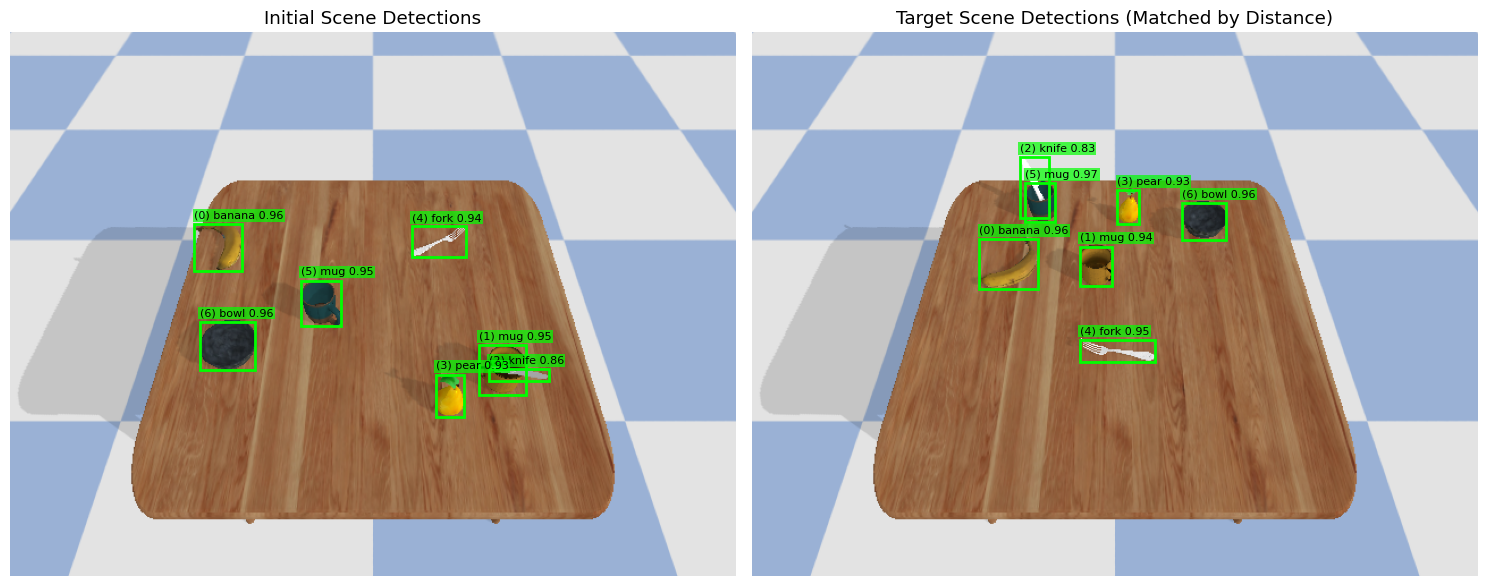

Initial Scene
  2  ⟶  1
Target Scene
  2  ⟶  5


In [39]:
initial_labels = os.path.join(folder_path, 'initial_labels.json')
init_img_path = os.path.join(folder_path, 'initial_image.png')
trgt_img_path = os.path.join(folder_path, 'target_image.png')

init_img = Image.open(init_img_path).convert("RGB")
trgt_img  = Image.open(trgt_img_path).convert("RGB")

class_map = {k: ('pot' if v == 'pan' else v) for k, v in yolo.names.items()}

# Get RAW detections first (use a lower confidence threshold to get more candidates)
raw_det_init = detect_objects(yolo, init_img, conf_thres=0.2, device=DEVICE)
raw_det_trgt = detect_objects(yolo, trgt_img, conf_thres=0.2, device=DEVICE)

# Mutual filtering by confidence to ensure both scenes agree on the objects
filtered_det_init, filtered_det_trgt = reciprocal_filter_with_nms(raw_det_init, raw_det_trgt, iou_threshold=0.3)

# Sort and validate detections against the ground truth labels
sorted_det_init = sort_and_validate_detections(initial_labels, filtered_det_init, class_map)
sorted_det_trgt = match_target_detections_by_distance(sorted_det_init, filtered_det_trgt)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
plot_detections(init_img_path, sorted_det_init, class_map, ax=ax1, title="Initial Scene Detections")
plot_detections(trgt_img_path, sorted_det_trgt, class_map, ax=ax2, title="Target Scene Detections (Matched by Distance)")
plt.tight_layout()
plt.show()

import pybullet as p
import pybullet_data
from core.sim.physics_utils import PyBulletSim, load_table_urdf, get_object_extents
from core.sim.camera_manager import CameraManager
from core.env.scene_manager import OBJECTS, Indices, SceneManager
from core.sim.rearrangemet_loader import world_to_grid_coords
OBJS_DIR = os.path.join('core', 'sim', 'objects')

with open(initial_labels, 'r') as f:
	labels = json.load(f)
cam_info = labels['camera_info']
viewpoint_id = cam_info['viewpoint_id']

x_init, x_trgt = create_x_from_det(sorted_det_init, sorted_det_trgt, init_img_path, trgt_img_path, model, viewpoint_id, class_map)


Initial Scene
  3  ⟶  1
Target Scene
  6  ⟶  1


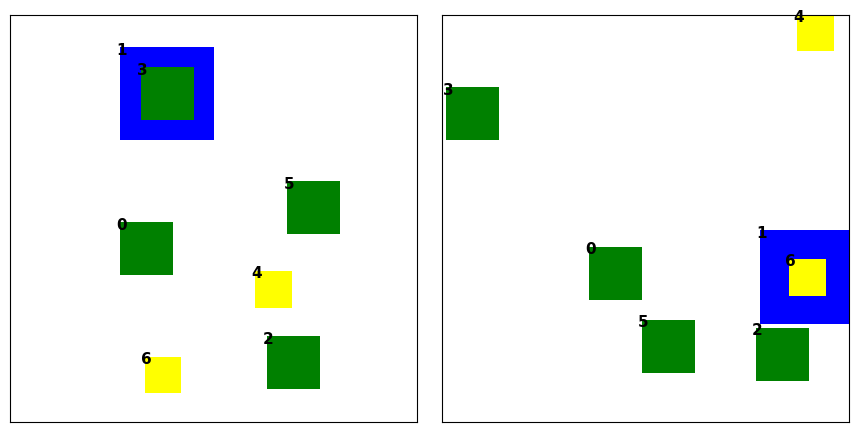

In [ ]:
num_objects = x_init.shape[0]
grid_size = (100, 100)
env = SceneManager(num_objects=num_objects, grid_size=grid_size, verbose=0)
env.reset(x_init, x_trgt)
env.render()